In [1]:
import matplotlib.pyplot as plt
import numpy as np
import igraph as ig

In [2]:
def move_element(X, x, i):
    element = X[x]  # Element to move
    X_right = X[:x] + X[x+1:]  # List without the element
    X_right.insert(i, element)  # Insert element at new position
    return X_right

def happy(X, x, neighbours, tr):
    sign = X[x]
    neighborhood = X[max(x - neighbours,0):min(x + neighbours + 1,len(X))]
    happiness = sum(neighborhood)
    if sign != 1:
        happiness = len(neighborhood) - happiness
    return happiness - 1 >= tr

def check_happy_state(X, neighbours, tr):
    for x in range(len(X)):
        if happy(X,x, neighbours, tr) == False:
            return False
    return True

def make_happy(X,x, neighbours, tr):
    # well check both left and right
    for i in range(1,len(X)//2,1):
        X_right = move_element(X,x, (x+i)%len(X))
        X_left  = move_element(X,x, (x-i)%len(X))
        if happy(X_right,(x+i)%len(X),neighbours, tr):
            return X_right
        elif happy(X_left,(x-i)%len(X),neighbours,tr):
            return X_left
    # in case happiness cannot be achieved
    return X

def make_happy_state(init, neighbours, tr):
    X_new = init.copy()
    if check_happy_state(X_new, neighbours, tr):
        return X_new
    for _ in range(2000):
        unhappy = []
        for x in range(len(init)):
            x_or = x
            if happy(X_new,x, neighbours,tr) == False:
                unhappy.append(x)
        x_choosen = np.random.choice(len(unhappy), 1, replace=False)[0]
        x_choosen = unhappy[x_choosen]
        X_new = make_happy(X_new,x_choosen,neighbours,tr)
        if check_happy_state(X_new, neighbours,tr):
            return X_new
        # lower the treshold by one, when people couldt be happy
        X_new = make_happy(X_new,x_choosen,neighbours,tr-1)
        if check_happy_state(X_new, neighbours,tr-1):
            return X_new
    return init

def number_groups(state):
    group_count = 1  # Start with one group assuming the sequence is not empty
    # Iterate through the sequence starting from the second element
    for i in range(1, len(state)):
        if state[i] != state[i - 1]:
            group_count += 1
    return group_count


False


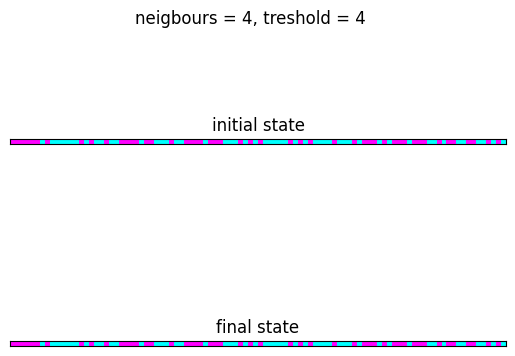

In [3]:
neighbours = 1
tr = 1
P = 0.5
N = 100

def play_game(neighbours = neighbours, tr = tr, P = P, N = N):
    init = list(np.random.choice(2, N, p=[P, 1-P]))
    final = make_happy_state(init,neighbours,tr)
    return init, final


def number_groups_game(neighbours = neighbours, tr = tr, P = P, N = N):
    init, final = play_game(neighbours = neighbours, tr = tr, P = P, N = N)
    return number_groups(final)


play_game = np.vectorize(play_game)
number_groups_game = np.vectorize(number_groups_game)


Neig, tr = 2,4
init,final = play_game(Neig,tr,0.5)
print(check_happy_state(final, Neig,tr))
# plotting
fig, ax = plt.subplots(2)
fig.suptitle(f'neigbours = {2*Neig}, treshold = {tr}')
ax[0].imshow([np.array(init)], cmap = 'cool')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('initial state')

ax[1].imshow([np.array(final)], cmap = 'cool')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('final state')
plt.show()


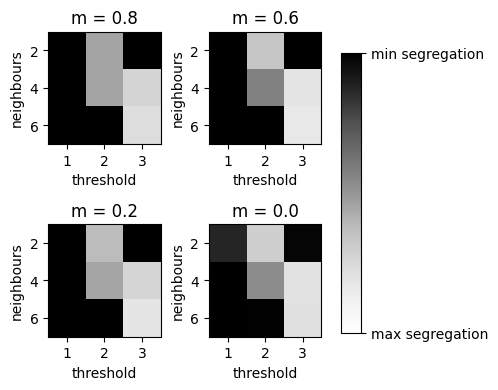

In [4]:
def parameter_plot(max_neighbours=4, max_tr=4, iterations=2, P = 0.1 ):
    vector_neighbours = np.arange(1, max_neighbours,1)
    vector_treshold = np.arange(1, max_tr,1)
    data_matrix = np.zeros((len(vector_neighbours), len(vector_treshold)))
    for _ in range(iterations):
        data_mat = np.zeros((len(vector_neighbours), len(vector_treshold)))
        # Create a meshgrid of indices for neighbours and threshold
        N, T = np.meshgrid(vector_neighbours, vector_treshold)
        # Vectorized calculation of data_mat using number_groups_game
        data_mat = number_groups_game(N, T,P = p)
        data_matrix += data_mat.transpose()
    return data_matrix / iterations

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (4,4))
fig.tight_layout()
P = [0.1,0.2,0.4,0.5]
for i, p in enumerate(P):
    ax = axs[i//2, i%2]
    data = parameter_plot(P = p)
    im = ax.imshow(data/(p*N+1), cmap = 'Greys')
    im.set_clim(0, 1)
    ax.set_xlabel('threshold')
    ax.set_ylabel('neighbours')
    ax.set_yticks(np.arange(0,data.shape[1]),np.arange(2,(data.shape[1]+1)*2,2))
    ax.set_xticks(np.arange(0,data.shape[0]),np.arange(1,data.shape[0] + 1))
    ax.set_title(f'm = {np.round(abs(p-0.5)*2, 2) }')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar =fig.colorbar(im, cax=cbar_ax)
cbar.set_ticks([0,1])
cbar.set_ticklabels(['max segregation', 'min segregation'])

plt.show()

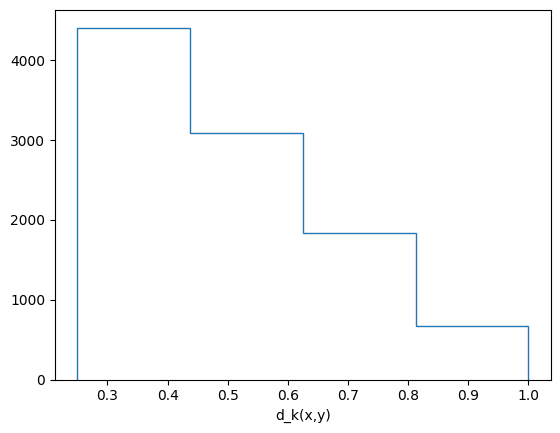

In [5]:
p = 0.4
K = 4
def d_K(x,y, K = K):
    d = min(abs(x-y +1),abs(x-y - 1),abs(x-y)) # torus metric from paper
    d  = abs(x-y)/2
    if d == 0: # every edge has a prob to be cut
        return 1/K
    else:
        return np.ceil(K*d)/K

# visualising the metric for uniform attribute distribution

X = np.random.uniform(low = -1, high = 1, size = 10000)
Y = np.random.uniform(low = -1, high = 1, size = 10000)

d_K = np.vectorize(d_K)
data = d_K(X,Y)
counts, bins = np.histogram(data, bins = K)
plt.stairs(counts, bins)
plt.xlabel('d_k(x,y)')
plt.show()

In [6]:
def edge_to_length(g, edge, K = K):
    u, v = edge[0], edge[1]
    u_atr, v_atr = g.vs['attribute'][u], g.vs['attribute'][v]
    length = d_K(u_atr,v_atr)
    return length

def distribution_length(g,K = K):
    edge_list = g.get_edgelist()
    list_length = []
    for edge in edge_list:
        list_length.append(edge_to_length(g,edge,K))
    return np.histogram(list_length, bins = K, range = (1/K,1))[0]


def segregate_network(g, steps, K):
    distr = []
    n = len(g.vs)
    for i in range(steps):
        distr.append(distribution_length(g,K))
        edge_list = g.get_edgelist()
        # selecting randomly an edge
        # going over all edges
        for edge in edge_list:
            # calculating the length of that edge
            u,v = edge
            length = edge_to_length(g,edge, K)
            if np.random.random() < length*p:
                # delete edge
                g.delete_edges(edge)
                # retrieve random node
                node_new = np.random.randint(0,n)
                # selecting which edge to form
                if np.random.random() < 0.5:
                    g.add_edges([(u,node_new)])
                else:
                    g.add_edges([(v,node_new)])
    return g, np.array(distr).transpose()



# running and plotting
def plot(g,ax,label,K = K, steps = 10, mean = 1):
    g_copy = g.copy()
    G ,distr= segregate_network(g_copy,steps,K)
    distr_tot = distr
    colors = ['blue', 'orange', 'green', 'red']
    for _ in range(mean):
        g_copy = g.copy()
        G, distr = segregate_network(g_copy, steps, K)
        distr_tot += distr
    retrieve = distr_tot.transpose()[-1]
    print(retrieve/sum(retrieve))
    labels = np.arange(1,K+1)/K
    for i,line in enumerate(distr_tot):
        if p < 0.5:
            ax.plot(np.arange(len(line)),line/sum(retrieve),ls = '--', color = colors[i])
        else:
            ax.plot(np.arange(len(line)),line/sum(retrieve), label = labels[i],ls = '-',color = colors[i])
    ax.set_ylim((-0.05,1.05))
    #ax.set_yticks([])
    ax.set_title(f'{label},n = {len(g.vs)}, m = {len(g.es)}')



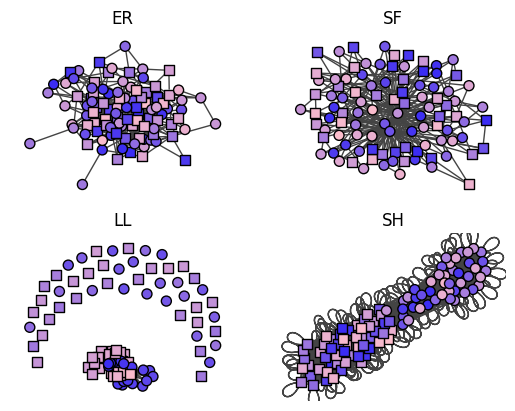

In [7]:
# constructing some graphs

# --- ERDOS RENYI  --- #
n = 100 #number of nodes
m = n*3 #number of edges
g = ig.Graph.Erdos_Renyi(n = n, m = m)

g.vs['attribute'] = np.random.uniform(-1,1,n)
vertex_colors = [int((i+1)*100) for i in g.vs['attribute']]

# --- BARABASI --- #
g_barb = ig.Graph.Barabasi(n,int(m/n), power = 2)
g_barb.vs['attribute'] = np.random.uniform(-1,1,n)
vertex_colors_barb = [int((i+1)*100) for i in g_barb.vs['attribute']]


# --- ONLY LONG EDGES ---#
n = 100
nodes = np.arange(0,n)
nodes_attribute = np.random.uniform(-1,1,n)
edges = []

for i in range(n):
    for j in range(i,n):

        if d_K(nodes_attribute[i], nodes_attribute[j]) == 1:
            edges.append((i,j))

g_long = ig.Graph(edges)
g_long.vs['attribute'] = nodes_attribute
vertex_colors_long = [int((i+1)*100) for i in g_long.vs['attribute']]


# --- ONLY SHORT EDGES ---
n = 100
nodes = np.arange(n)
nodes_attribute = np.random.uniform(-1,1,n)
edges = []

for i in range(n):
    for j in range(i,n):
        if d_K(nodes_attribute[i], nodes_attribute[j]) == 1/K:
            edges.append((i,j))

g_short = ig.Graph(edges)
g_short.vs['attribute'] = nodes_attribute
vertex_colors_short = [int((i+1)*100) for i in g_long.vs['attribute']]


def plot_graphs(G,ax,label):
    ax.set_title(label)
    shape_dict = {-1.0:"rectangle",1.0:"circle" }
    ig.plot(G,
    layout = 'fr',
    palette = ig.GradientPalette('pink', 'blue'),
    vertex_color = vertex_colors_short,
    vertex_label = [''],
    vertex_shape = [shape_dict[np.sign(attr)] for attr in G.vs["attribute"]],
    vertex_size = 10,
    edge_width = 1,
    target = ax)

fig, axs = plt.subplots(nrows = 2,ncols = 2)

graphs = [(g, axs[0,0], 'ER'),
 (g_barb, axs[0,1], 'SF'),
  (g_long, axs[1,0], 'LL'),
   (g_short, axs[1,1], 'SH')]



for graph in graphs:
  plot_graphs(*graph)



[0.40333333 0.32333333 0.19       0.08333333]
[0.43197279 0.30952381 0.21428571 0.04421769]
[0. 0. 0. 1.]
[1. 0. 0. 0.]
[0.40333333 0.32333333 0.19       0.08333333]
[0.43197279 0.30952381 0.21428571 0.04421769]
[0. 0. 0. 1.]
[1. 0. 0. 0.]


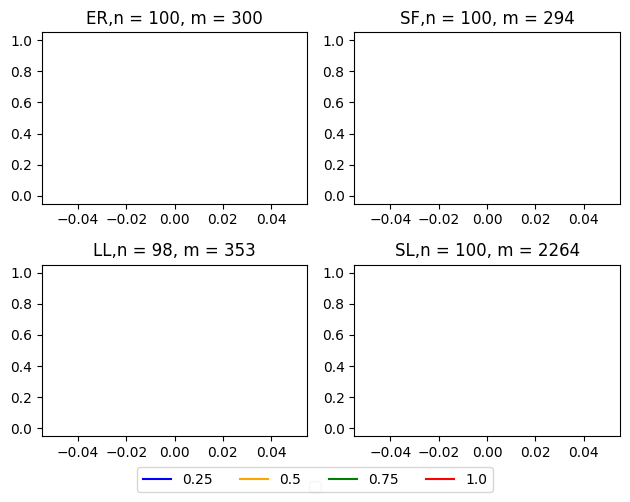

In [8]:
fig, axs = plt.subplots(nrows = 2,ncols = 2)
for p in np.linspace(0.1,1,2):
    graphs = [(g, axs[0,0], 'ER'),
    (g_barb, axs[0,1], 'SF'),
        (g_long, axs[1,0], 'LL'),
        (g_short, axs[1,1], 'SL')]
    for graph in graphs:
        plot(*graph, K = K, mean = 30, steps = 100)
    handles, labels = plt.gca().get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05),ncols = 4)
    plt.tight_layout()




In [9]:
def happy_nodes(state_or, neighbours = 1, f = 0):
    """
    Function that translates position vector into utility vector
    and calculates the density of the happy nodes.
    Also returns a vector of the utility  of the empty sites if
    a node would move there. Density is calculated
    with respect to non-zero nodes. Boundary conditions are periodic.
    ________

    input:

     - state_or: state vector
     - Neighbours: number of closest cells on each side
     - f: utility treshhold for happiness

     output:

     - utility_return: utility vector of nodes. Sites with 0 are given zero.
     - happy: density of happy nodes with respect to non-0 nodes
     - utility_empty:

    """
    utility_return  = np.zeros(len(state_or))
    utility_empty = np.zeros(len(state_or))
    state = state_or.copy()
    for i in range(1,neighbours+1):
        shift_R = np.roll(state, i)
        shift_L = np.roll(state, -i)
        utility_return = utility_return + (shift_L + shift_R)*state
        utility_empty += shift_R + shift_L
    utility_return  = utility_return/2/neighbours
    unhappy_mask = (utility_return < f) & (state_or != 0)
    utility_empty = np.where(state_or == 0 ,utility_empty,2*neighbours+1)
    utility_empty = np.array(utility_empty,dtype= int)/2/neighbours
    unhappy_indexes = np.nonzero(unhappy_mask)[0]
    happy = len(unhappy_indexes)
    return utility_return, utility_empty, happy/(sum(state_or*state_or))
m = 0
p = 0.3
f_eq = 0
N  = 10
for _ in range(3):
    example = np.random.choice(3, N, p=[(1-p)*(1-m)/2, p, (1-p)*(1+m)/2]) - 1
    print(example,':example')
    i,j,k =happy_nodes(example)
    print(i, ':utility')
    print(j,':possible utility')
    print(np.round(k,3), ':density unhappy')
    print('-----')


[ 1 -1  1  1  1  1  1 -1 -1  0] :example
[-0.5 -1.   0.   1.   1.   1.   0.   0.   0.5  0. ] :utility
[1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 0. ] :possible utility
0.222 :density unhappy
-----
[-1  0 -1  1 -1  1  0  0 -1 -1] :example
[ 0.5  0.  -0.5 -1.  -1.  -0.5  0.   0.   0.5  1. ] :utility
[ 1.5 -1.   1.5  1.5  1.5  1.5  0.5 -0.5  1.5  1.5] :possible utility
0.571 :density unhappy
-----
[ 0  1  0 -1 -1 -1 -1  0 -1  1] :example
[ 0.   0.   0.   0.5  1.   1.   0.5  0.  -0.5 -0.5] :utility
[ 1.   1.5  0.   1.5  1.5  1.5  1.5 -1.   1.5  1.5] :possible utility
0.286 :density unhappy
-----


In [10]:
def update_happy_nodes(state_or, neighbours=1,f = 0, Print = False):
    utility, possible_utility,dens_unhappy = happy_nodes(state_or, neighbours,f)
    # finding the unhappy nodes
    # their utility is smaller than f, and exclude the nodes with state 0
    unhappy_mask = (utility < f) & (state_or != 0)
    unhappy_indexes = np.nonzero(unhappy_mask)[0]
    # if there are no unhappy nodes, return
    if len(unhappy_indexes) == 0:
        if Print:
            print("no unhappy nodes")
        return state_or, dens_unhappy
    # taking a random unhappy index
    lucky_index = np.random.choice(unhappy_indexes)
    state_index = np.sign(state_or[lucky_index])
    # we change the possible utility, in such a way that it becomes a
    # probability distribution => taken sites become zero, empty sites
    # fulfilling the requirements become 1
    prob_distr = ((possible_utility <= 1) &
            (possible_utility*state_index> utility[lucky_index]))
    prob_distr = prob_distr.astype(float)
    norm = prob_distr.sum()
    # if situation does not get better, return
    if norm == 0:
        if Print:
            print('index, utility, state:',lucky_index, utility[lucky_index], state_or[lucky_index])
            print(possible_utility, "possible utility")
            print(prob_distr, ':prob_distr')
            print("no improvement possible")
        return state_or, dens_unhappy
    new_index = np.random.choice(np.arange(len(state_or)), p=prob_distr / norm)
    state_return = state_or.copy()
    state_return[lucky_index], state_return[new_index] = state_or[new_index], state_or[lucky_index]
    if Print:
        print('index, utility, state:',lucky_index, utility[lucky_index], state_or[lucky_index])
        print(possible_utility, ':possible utility')
        print(prob_distr, ': probability distr')
        print(state_return, 'new state')
    # note, instead of recalculating the happy or not, i return the previous dens
    # an error that selfs itself the next iteration
    return state_return, dens_unhappy
m = 0
p = 0.3
f_eq = 0
N  = 10
for _ in range(3):
    example =np.random.choice(3, N, p=[(1-p)*(1-m)/2, p, (1-p)*(1+m)/2]) - 1
    print(example,':example')
    update_happy_nodes(example, Print  = True)
    print('--------------')
    print()

[ 1  0 -1  1 -1  0  1 -1 -1  1] :example
index, utility, state: 4 -0.5 -1
[1.5 0.  1.5 1.5 1.5 0.  1.5 1.5 1.5 1.5] :possible utility
[0. 1. 0. 0. 0. 1. 0. 0. 0. 0.] : probability distr
[ 1 -1 -1  1  0  0  1 -1 -1  1] new state
--------------

[-1 -1 -1  0 -1 -1  0  1 -1  0] :example
index, utility, state: 8 -0.5 -1
[ 1.5  1.5  1.5 -1.   1.5  1.5  0.   1.5  1.5 -1. ] :possible utility
[0. 0. 0. 1. 0. 0. 1. 0. 0. 1.] : probability distr
[-1 -1 -1  0 -1 -1 -1  1  0  0] new state
--------------

[-1  1 -1  0  1 -1  1 -1  0 -1] :example
index, utility, state: 1 -1.0 1
[ 1.5  1.5  1.5  0.   1.5  1.5  1.5  1.5 -1.   1.5] :possible utility
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] : probability distr
[-1  0 -1  1  1 -1  1 -1  0 -1] new state
--------------



index, utility, state: 16 -1.0 1
[ 1.5  1.5  1.5 -1.   1.5  1.5  1.5  1.   1.5  1.   1.5  1.5  1.5  1.5
  1.5  1.5  1.5  1.5  1.5  0. ] :possible utility
[0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] : probability distr
[-1  1 -1  0 -1  1  1  0  1  1  1 -1 -1 -1 -1 -1  0 -1  1  0] new state
---------
index, utility, state: 1 -1.0 1
[ 1.5  1.5  1.5 -1.   1.5  1.5  1.5  1.   1.5  1.5  1.5  1.5  1.5  1.5
  1.5  1.5 -1.   1.5  1.5  0. ] :possible utility
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] : probability distr
[-1  0 -1  0 -1  1  1  1  1  1  1 -1 -1 -1 -1 -1  0 -1  1  0] new state
---------
index, utility, state: 17 -0.5 -1
[ 1.5 -1.   1.5 -1.   1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5
  1.5  1.5 -1.   1.5  1.5  0. ] :possible utility
[0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.] : probability distr
[-1 -1 -1  0 -1  1  1  1  1  1  1 -1 -1 -1 -1 -1  0  0  1  0] new state
---------


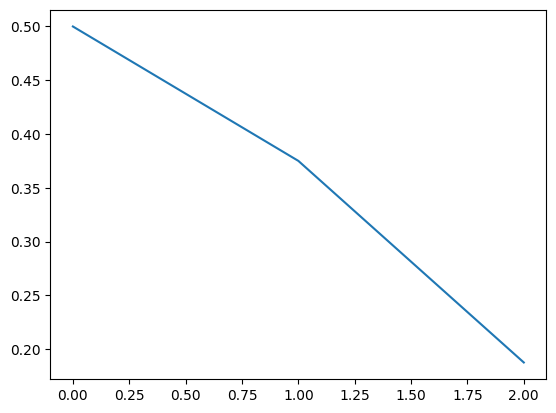

In [11]:
def get_final_dens_unhappy(N, m, p, iterations,neighbours,f_eq, Print = False):
    densities = []
    states = []
    init_old = np.random.choice(3, N, p=[(1-p)*(1-m)/2, p, (1-p)*(1+m)/2]) - 1
    for i in range(iterations):
        init_new, dens = update_happy_nodes(init_old, neighbours, f=f_eq, Print = Print)
        densities.append(dens)
        init_old = init_new
        states.append(init_old)
        if Print:
            print("---------")
        if i > 0.1 * iterations and len(set(densities[-int(0.2 * iterations):])) < 2:
            break
    return densities, states
# Parameters for the function
N = 20
m = 0
p = 0.2
neighbours = 1
iterations = 3
f = 0
Print = True
# Get the final densities and states
dens, states = get_final_dens_unhappy(N, m, p,iterations,neighbours,f, Print)
plt.plot(dens)


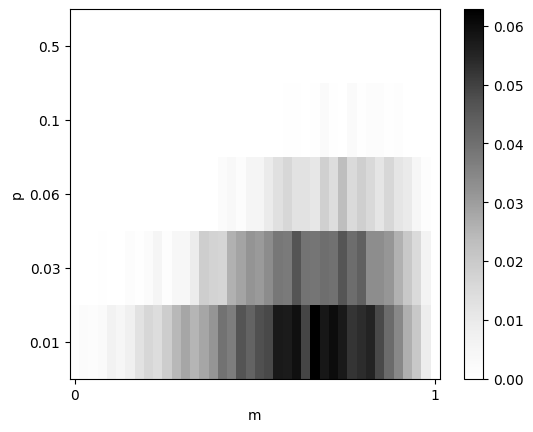

In [12]:
def m_vs_p(N, neighbours, iterations, mean, f_eq = 0):
    dim  = 40
    M = np.linspace(0, 1, dim)
    P = [0.01,0.03,0.06,0.1,0.5]
    data_matrix = np.zeros((len(P), len(M)))
    for i, p in enumerate(P):
        for j, m in enumerate(M):
            check = 0
            for _ in range(mean):
                    check += get_final_dens_unhappy(N, m, p, iterations, neighbours, f_eq)[0][-1]
            data_matrix[i, j] = check/mean
    fig, ax = plt.subplots()
    image = ax.imshow(data_matrix, cmap='Greys', origin='lower', aspect=int(len(M)/len(P)))
    plt.colorbar(image)
    ax.set_xlabel('m')
    ax.set_ylabel('p')
    ax.set_xticks([0,dim - 1], [0,1])
    ax.set_yticks(np.arange(len(P)), P)
    plt.show()



def u_vs_p(N,m, neighbours,f_eq, iterations, mean):
    dim = 20
    P = np.linspace(0, 0.9, dim)
    data = []
    for p in P:
        check = 0
        for _ in range(mean):
            check += get_final_dens_unhappy(N, m, p, iterations, neighbours, f_eq)[0][-1]
        data.append([p, check/mean])
    data = np.array(data).T
    plt.plot(data[0], data[1])
    plt.xlabel('p')
    plt.ylabel('Density of unhappy nodes')
    plt.show()

# Parameters for the function
N = 100
m = 0
p = 0.2
neighbours = 1
iterations = 100
f = 0
mean = 10


m_vs_p(N, neighbours, iterations, mean)
#u_vs_p(N,m, neighbours, f,iterations, mean)

visualising the matrix plot, we have a couple of imidiate checks:
- $u_\infty$ is supposed to vanish at m=0 and m =1 and for large enough $\rho_0$. The first because, as long as there is 1 empty site, nodes can gradually improve their utility and an configuration where everybody is happy is always obtainable (assuming m = 0).

- For m=1 by definition there are no unhappy node.

- For large enough $\rho_0$, it vanishes because nodes, in worst case scenario, live on their own, which is a happy configuration when f = 1/2.

the reason why there is a peak in unhappiness is because of the decrease of minority. The minority will be on average less satisfied the smaller it becomes, but this becomes negated by the increase of the happy majority. Hence, on average, more people are happy.




## Unconstrained model
nodes are free to move as long as their utility does not decrease. This means that there will always be dynamics. Given the way we code so far we only have to modify the 'update_happy_nodes function slightly, and introduce **n** which defines the fraction of neighboring spins of opposite type.


In [13]:
def happy_nodes_unconstrained(state_or, neighbours = 1, f = f_eq):
    """
    Function that translates position vector into utility vector
    and calculates the density of the happy nodes.
    Also returns a vector of the utility  of the empty sites if
    a node would move there. Density is calculated
    with respect to non-zero nodes. Boundary conditions are periodic.
    ________

    input:

     - state_or: state vector
     - Neighbours: number of closest cells on each side
     - f: utility treshhold for happiness

     output:

     - utility_return: utility vector of nodes. Sites with 0 are given zero.
     - happy: density of happy nodes with respect to non-0 nodes
     - utility_empty:

    """
    utility_return  = np.zeros(len(state_or))
    utility_empty = np.zeros(len(state_or))
    state = state_or.copy()
    for i in range(1,neighbours+1):
        shift_R = np.roll(state, i)
        shift_L = np.roll(state, -i)
        utility_return = utility_return + (shift_L + shift_R)*state
        utility_empty += shift_R + shift_L
    utility_return  = utility_return/2/neighbours
    unhappy_mask = (utility_return < f) & (state_or != 0)
    utility_empty = np.where(state_or == 0 ,utility_empty,2*neighbours+1)
    utility_empty = np.array(utility_empty,dtype= int)/2/neighbours
    unhappy_indexes = np.nonzero(unhappy_mask)[0]
    unhappy = len(unhappy_indexes)
    # intefaces: go through state, when differences between 2 neighbouring sites is larger than 1,
    # then we have opposite spins.
    group_count = 0
    for i in range(1, len(state)):
        if abs(state[i] - state[i - 1]) > 1:
            group_count += 1
    return utility_return, utility_empty, unhappy/(sum(state_or*state_or)), group_count/(sum(state_or*state_or))


m = 0.1
p = 0.1
f_eq = 0
N  = 10

for _ in range(3):
    example = np.random.choice(3, N, p=[(1-p)*(1-m)/2, p, (1-p)*(1+m)/2]) - 1
    print(example,':example')
    i,j,k,h =happy_nodes_unconstrained(example)
    print(i, ':utility')
    print(j,':possible utility')
    print(np.round(k,3), ':density unhappy')
    print(np.round(h,3), ':interfaces unhappy')
    print('-----')

[-1  0  1  1 -1 -1  1  1  1 -1] :example
[0.5 0.  0.5 0.  0.  0.  0.  1.  0.  0. ] :utility
[1.5 0.  1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5] :possible utility
0.0 :density unhappy
0.333 :interfaces unhappy
-----
[ 1 -1  1  1  0 -1  0  1  1  1] :example
[ 0.  -1.   0.   0.5  0.   0.   0.   0.5  1.   1. ] :utility
[1.5 1.5 1.5 1.5 0.  1.5 0.  1.5 1.5 1.5] :possible utility
0.125 :density unhappy
0.25 :interfaces unhappy
-----
[-1  1  1 -1  1  1 -1 -1  1 -1] :example
[ 0.  0.  0. -1.  0.  0.  0.  0. -1.  0.] :utility
[1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5] :possible utility
0.2 :density unhappy
0.6 :interfaces unhappy
-----


In [14]:
def update_happy_nodes_unconstrained(state_or, neighbours=1,f = f_eq, bi = False, Print = False):
    utility, possible_utility,dens_unhappy, interfaces= happy_nodes_unconstrained(state_or, neighbours,f)
    #  here are no unhappy nodes, so we only have to exlude the empty site indexes
    non_empty_sites_mask = (state_or != 0)
    non_empty_indexes = np.nonzero(non_empty_sites_mask)[0]
    if len(non_empty_indexes) ==0:
        return  utility,np.array([dens_unhappy, interfaces])
    # taking a random unhappy index
    lucky_indexes = np.random.permutation(non_empty_indexes)
    for i in range(len(non_empty_indexes)):
        if Print:
            print('tries before finding node:', i)
        lucky_index = lucky_indexes[i]
        state_index = np.sign(state_or[lucky_index])
        # we change the possible utility, in such a way that it becomes a
        # probability distribution => taken sites become zero, empty sites
        # fulfilling the requirements become 1
        # here now empty sites with same utility are also selected
        if bi:
            prob_distr = ((possible_utility <= 1) &
                    (possible_utility*state_index>=  f))
        else:
                        prob_distr = ((possible_utility <= 1) &
                    (possible_utility*state_index>=  utility[lucky_index]))

        prob_distr = prob_distr.astype(float)
        norm = prob_distr.sum()
        if norm != 0:
            new_index = np.random.choice(np.arange(len(state_or)), p=prob_distr / norm)
            state_return = state_or.copy()
            state_return[lucky_index], state_return[new_index] = state_or[new_index], state_or[lucky_index]
            if Print:
                print('index, utility, state:',lucky_index, utility[lucky_index], state_or[lucky_index])
                print(possible_utility, ':possible utility')
                print(prob_distr, ': probability distr')
                print(state_return, 'new state')
            # note, instead of recalculating the happy or not, i return the previous dens
            # an error that solves itself the next iteration. same for the interface.
            return state_return, np.array([dens_unhappy, interfaces])
    if Print:
        print('no node could have been found which could move without worsening utility')
    return state_or, np.array([dens_unhappy, interfaces])

m = 0
p = 0.2
f_eq = 0
N  = 10

for _ in range(3):
    example = np.random.choice(3, N, p=[(1-p)*(1-m)/2, p, (1-p)*(1+m)/2]) - 1
    print(example,':example')
    update_happy_nodes_unconstrained(example, Print  = True)
    print('--------------')
    print()
print('# --- bi --- #')
for _ in range(3):
    example = np.random.choice(3, N, p=[(1-p)*(1-m)/2, p, (1-p)*(1+m)/2]) - 1
    print(example,':example')
    update_happy_nodes_unconstrained(example, Print  = True, bi = True)
    print('--------------')
    print()

[ 1  0 -1  0 -1  1 -1 -1 -1  0] :example
tries before finding node: 0
index, utility, state: 2 0.0 -1
[ 1.5  0.   1.5 -1.   1.5  1.5  1.5  1.5  1.5  0. ] :possible utility
[0. 1. 0. 1. 0. 0. 0. 0. 0. 1.] : probability distr
[ 1 -1  0  0 -1  1 -1 -1 -1  0] new state
--------------

[-1  0  1 -1  1  1 -1  1  1  1] :example
tries before finding node: 0
index, utility, state: 7 0.0 1
[1.5 0.  1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5] :possible utility
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] : probability distr
[-1  1  1 -1  1  1 -1  0  1  1] new state
--------------

[-1  0  1  1 -1 -1  1  1 -1  1] :example
tries before finding node: 0
index, utility, state: 9 -1.0 1
[1.5 0.  1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5] :possible utility
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] : probability distr
[-1  1  1  1 -1 -1  1  1 -1  0] new state
--------------

# --- bi --- #
[ 1 -1  1  0  1 -1 -1 -1  1 -1] :example
tries before finding node: 0
index, utility, state: 2 -0.5 1
[1.5 1.5 1.5 1.  1.5 1.5 1.5 1.5 1.5 1.5] :possible utilit

In [15]:
def get_final_dens_unhappy_unconstrained(N, m, p, iterations,neighbours,f_eq, bi = False,Print = False):
    densities = []
    states = []
    init_old = np.random.permutation(int(p*N)*[0]+ int((1-p)*(1-m)*N/2)*[-1] +int((1-p)*(1+m)*N/2)*[1])
    for i in range(iterations):
        init_new, dens = update_happy_nodes_unconstrained(init_old, neighbours, f=f_eq,bi = bi,  Print = Print)
        states.append(init_old)
        densities.append(dens)
        if list(init_old) == list(init_new):
            for _ in range(iterations - len(states)):
                states.append(list(init_old))
                densities.append(densities[-1])
            return densities, states
        init_old = init_new
        if Print:
            print("---------")
    return densities, states

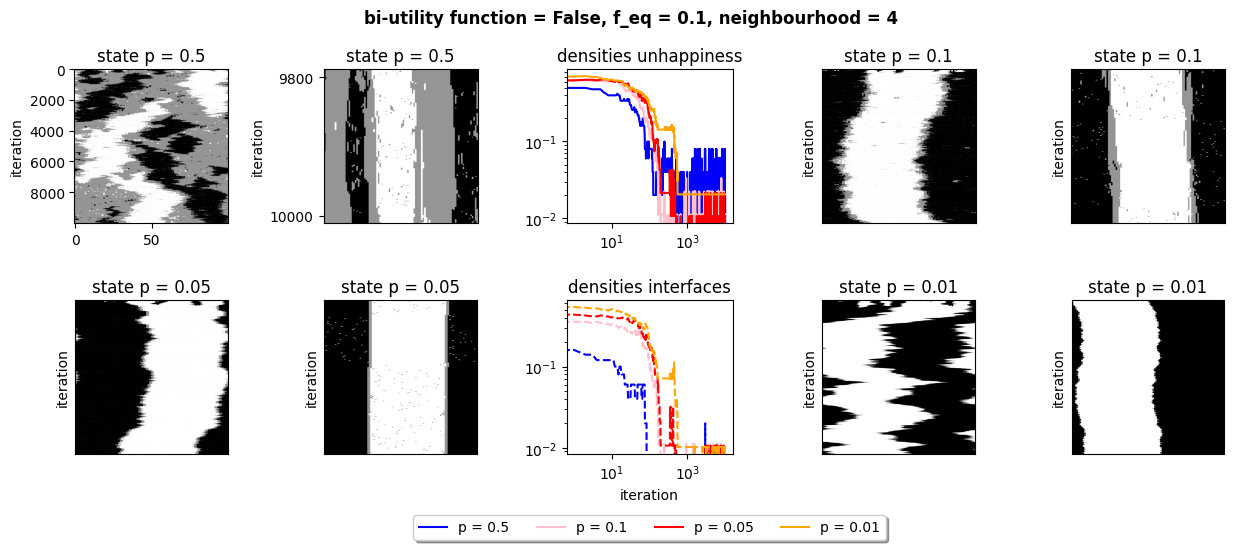

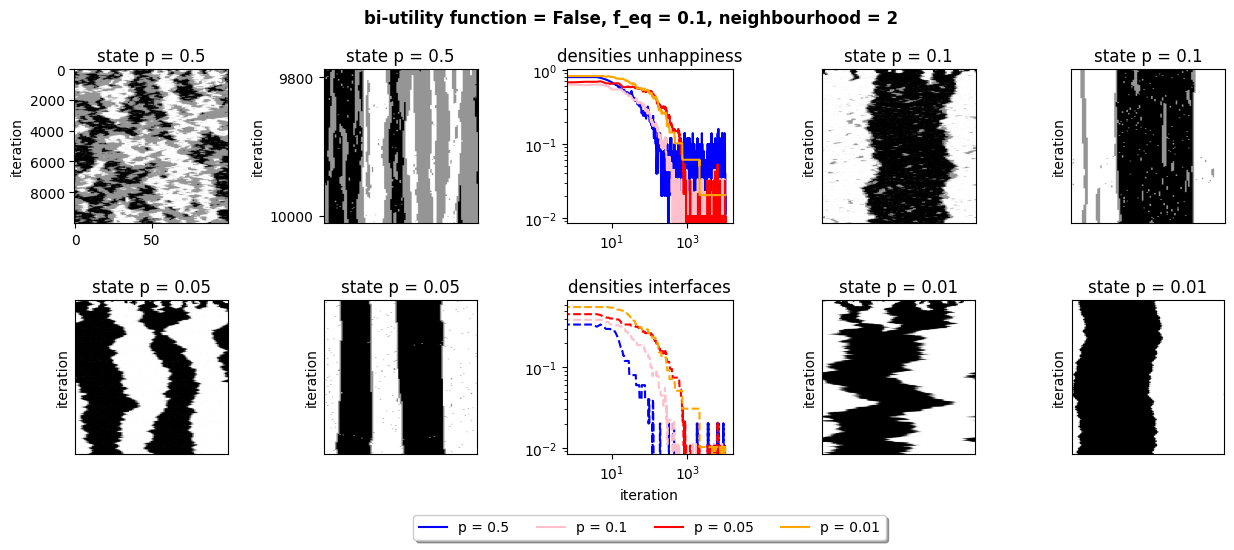

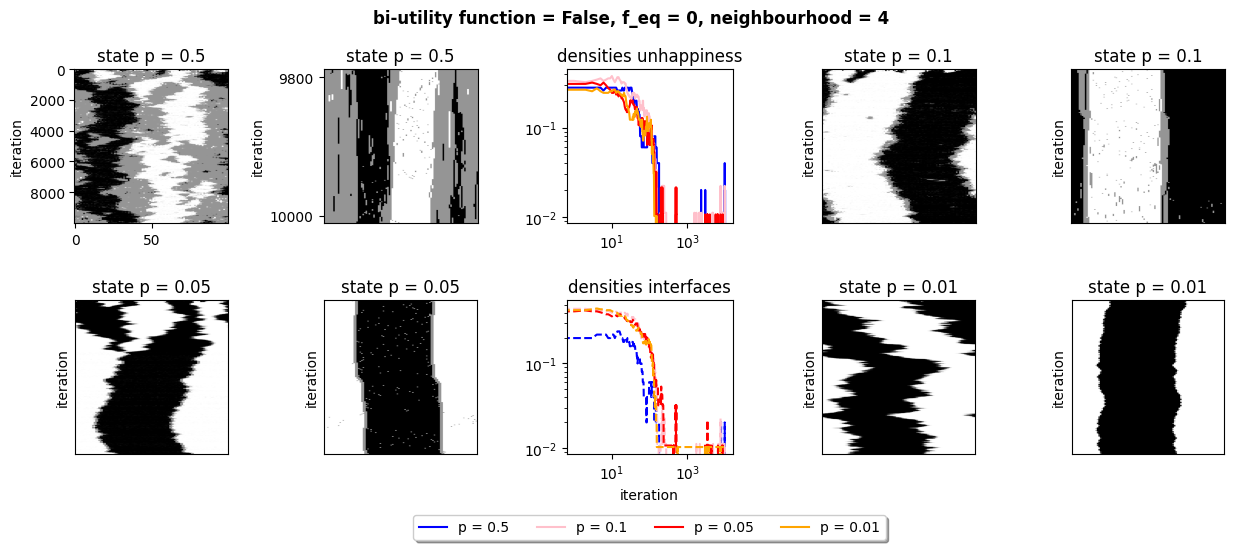

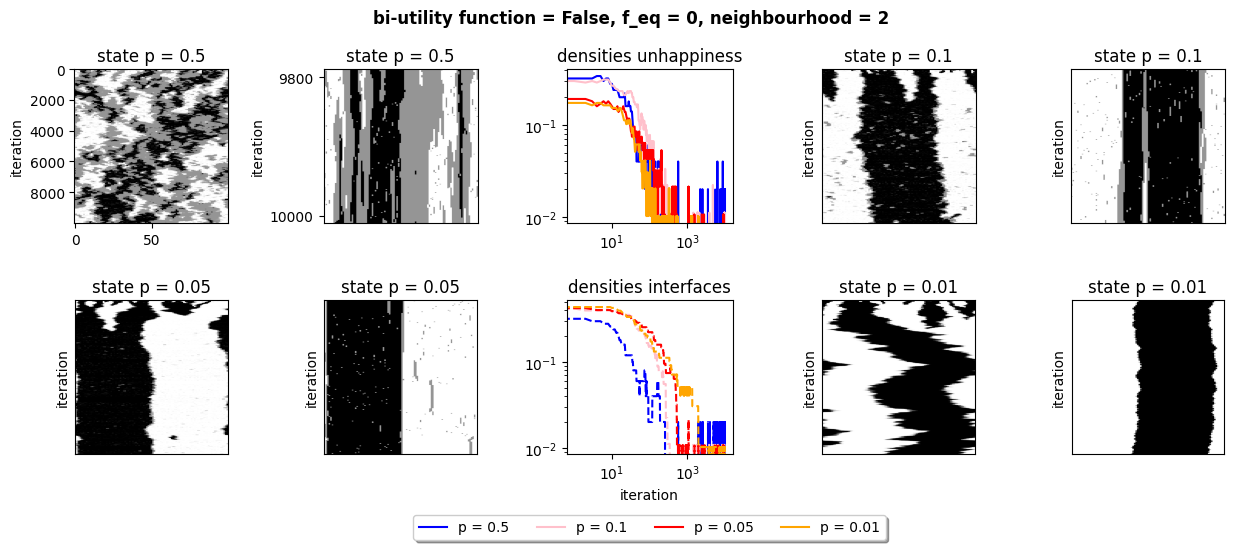

In [16]:
def plot(N,m,p1,p2,p3,p4, iterations,bi, neigh = 1, f = 0):

    densities1, states1 = get_final_dens_unhappy_unconstrained(N = N, m = m,p = p1,f_eq = f, neighbours=neigh, iterations=iterations, bi = bi)
    densities1 = np.array(densities1).transpose()
    u1,n1 = densities1[0], densities1[1]
    densities2, states2 = get_final_dens_unhappy_unconstrained(N = N, m = m,p = p2,f_eq = f, neighbours=neigh, iterations=iterations, bi = bi)
    densities2 = np.array(densities2).transpose()
    u2,n2 = densities2[0], densities2[1]
    densities3, states3 = get_final_dens_unhappy_unconstrained(N = N, m = m,p = p3,f_eq = f, neighbours=neigh, iterations=iterations, bi = bi)
    densities3 = np.array(densities3).transpose()
    u3,n3 = densities3[0], densities3[1]
    densities4, states4 = get_final_dens_unhappy_unconstrained(N = N, m = m,p = p4,f_eq = f, neighbours=neigh, iterations=iterations,bi = bi)
    densities4 = np.array(densities4).transpose()
    u4,n4 = densities4[0], densities4[1]
    fig, ax = plt.subplots(2,5, figsize = (15,5))
    plt.subplots_adjust(hspace = 0.3, wspace = 0.1 )
    ax[0,0].imshow(states1, cmap = 'Greys', aspect = N/iterations)
    #ax[0,0].set_xticks([ ])
    ax[0,0].set_ylabel('iteration')
    ax[0,0].set_title(f'state p = {p1}')
    ax[0,1].imshow(states1[-200:], cmap = 'Greys', aspect = 1/2)#, aspect = N/iterations)
    ax[0,1].set_xticks([ ])
    ax[0,1].set_yticks([10, 190],[iterations - 200, iterations])
    ax[0,1].set_ylabel('iteration')
    ax[0,1].set_title(f'state p = {p1}')
    ax[0,3].imshow(states2, cmap = 'Greys', aspect = N/iterations)
    ax[0,3].set_yticks([ ])
    ax[0,3].set_xticks([ ])
    ax[0,3].set_ylabel('iteration')
    ax[0,3].set_title(f'state p = {p2}')
    ax[0,4].imshow(states2[-200:], cmap = 'Greys', aspect = 1/2)
    ax[0,4].set_yticks([ ])
    ax[0,4].set_xticks([ ])
    ax[0,4].set_ylabel('iteration')
    ax[0,4].set_title(f'state p = {p2}')
    ax[1,0].imshow(states3, cmap = 'Greys', aspect = N/iterations)
    ax[1,0].set_yticks([ ])
    ax[1,0].set_xticks([ ])
    ax[1,0].set_ylabel('iteration')
    ax[1,0].set_title(f'state p = {p3}')
    ax[1,1].imshow(states3[-200:], cmap = 'Greys', aspect = 1/2)
    ax[1,1].set_yticks([ ])
    ax[1,1].set_xticks([ ])
    ax[1,1].set_ylabel('iteration')
    ax[1,1].set_title(f'state p = {p3}')
    ax[1,4].imshow(states4[-200:], cmap = 'Greys', aspect = 1/2)
    ax[1,4].set_xticks([ ])
    ax[1,4].set_yticks([ ])
    ax[1,4].set_ylabel('iteration')
    ax[1,4].set_title(f'state p = {p4}')
    ax[1,3].imshow(states4, cmap = 'Greys', aspect = N/iterations)
    ax[1,3].set_xticks([ ])
    ax[1,3].set_yticks([ ])
    ax[1,3].set_ylabel('iteration')
    ax[1,3].set_title(f'state p = {p4}')
    ax[0,2].plot(np.arange(iterations),u1, label = f'p = {p1}', color = 'blue', ls = '-')
    ax[0,2].plot(np.arange(iterations),u2, label = f'p = {p2}', color = 'pink', ls = '-')
    ax[0,2].plot(np.arange(iterations),u3, label = f'p = {p3}', color = 'red', ls = '-')
    ax[0,2].plot(np.arange(iterations),u4, label = f'p = {p4}', color = 'orange', ls = '-')
    ax[0,2].set_xscale('log')
    ax[0,2].set_yscale('log')
    ax[0,2].set_title('densities unhappiness')
    ax[1,2].plot(np.arange(iterations),n1, color = 'blue', ls = '--')
    ax[1,2].plot(np.arange(iterations),n2, color = 'pink', ls = '--')
    ax[1,2].plot(np.arange(iterations),n3, color = 'red', ls = '--')
    ax[1,2].plot(np.arange(iterations),n4, color = 'orange', ls = '--')
    ax[1,2].set_xscale('log')
    ax[1,2].set_yscale('log')
    ax[1,2].set_xlabel('iteration')

    ax[1,2].set_title('densities interfaces')

    fig.suptitle(f'bi-utility function = {bi}, f_eq = {f}, neighbourhood = {2*neigh}',  fontweight="bold", y = 1)
    ax[0,2].legend(loc='upper center', bbox_to_anchor=(0.5, -1.85),
          fancybox=True, shadow=True, ncol=5)
    fig.subplots_adjust(hspace = +0.5, wspace = 0.5 )

    plt.show()

N =100
m = 0
neighbours = 1
iterations = 10*N

p1 = 0.5
p2 =0.1
p3 = 0.05
p4 = 0.01


plot(N,m,p1,p2,p3,p4,iterations,False, f = 0.1, neigh= 2)
plot(N,m,p1,p2,p3,p4,iterations,False, f = 0.1, neigh = 1)
plot(N,m,p1,p2,p3,p4,iterations,False, f = 0, neigh = 2)
plot(N,m,p1,p2,p3,p4,iterations,False, f = 0, neigh = 1)

there is clearly some scaling going on, as we can see in the state plots; in the beginning it is more mixed,
while at the end it is completely segregated, with in the middle a drastic phase transition.
However, I am not able te reproduce the plot of the paper. we do see that the amount of aggregated groups is inversely correlated with the density of empty sites. This can be explained by the fact that they act as a buffer between the groups

### Unconstrained model with binary utility.
We can go though the same dynamics, but now considering only 2 states: happy or unhappy. A node cannot be more happy if it already is happy.

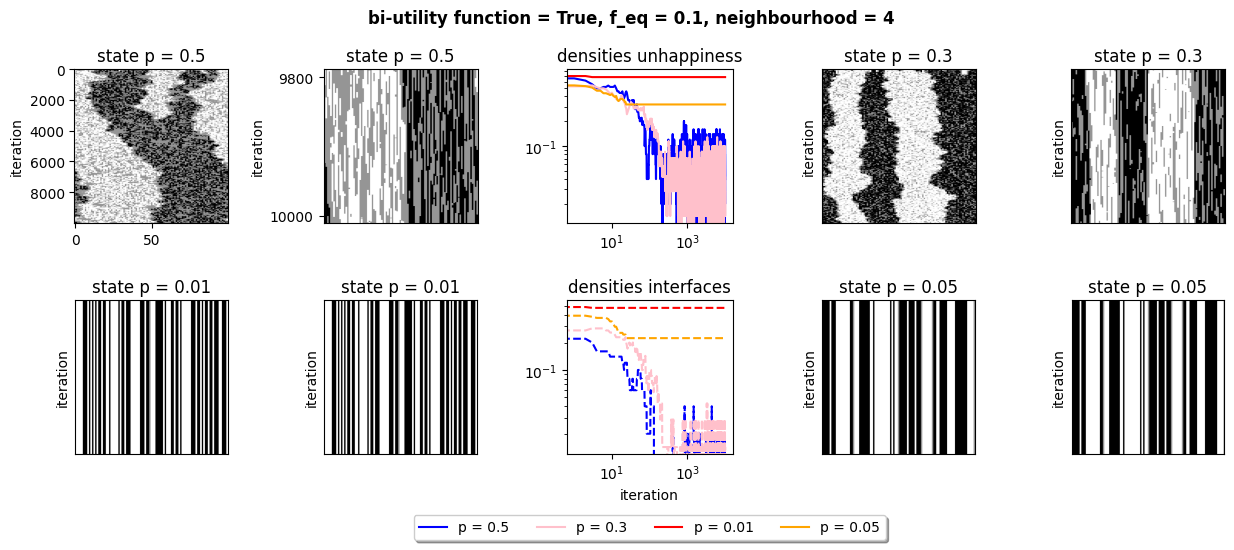

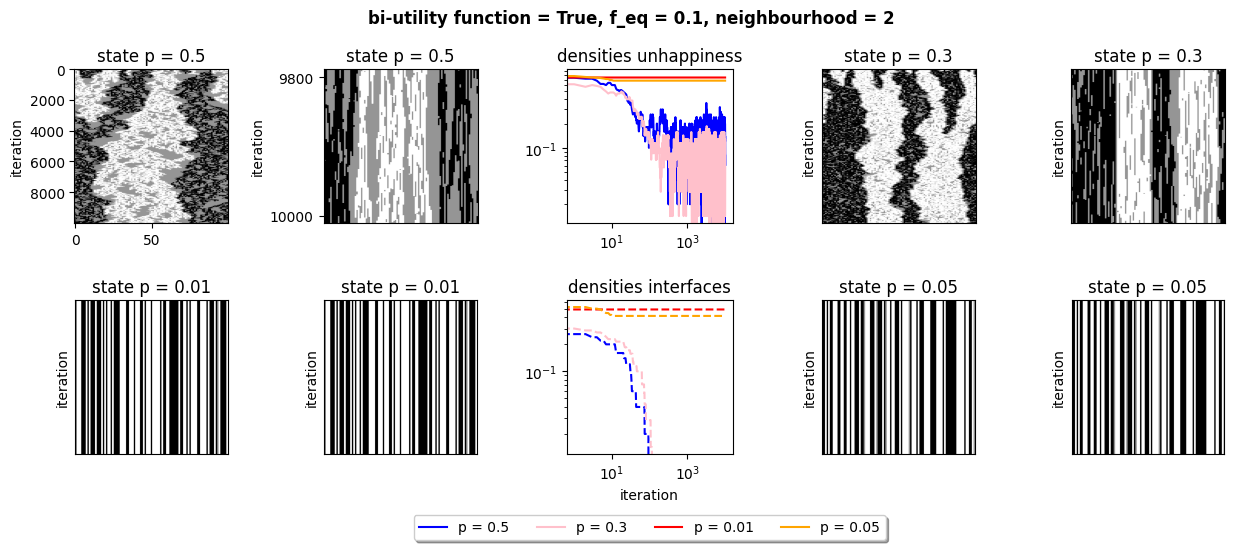

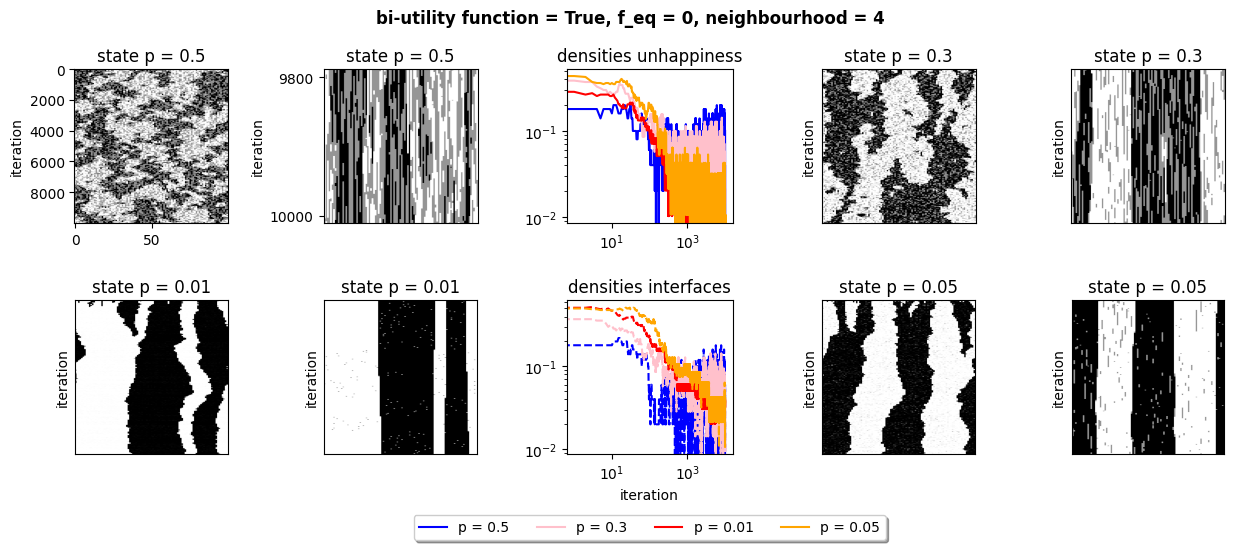

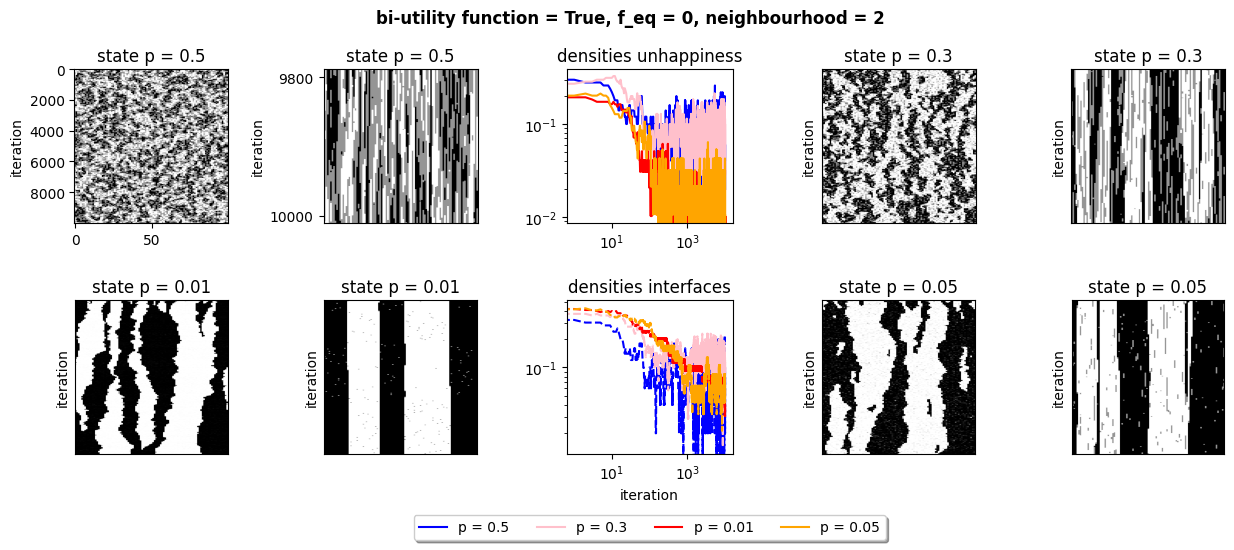

In [17]:
N =100
m = 0
neighbours = 1
iterations = 10*N
bi = True

p1 = 0.5
p2 =0.3
p3 = 0.01
p4 = 0.05

plot(N,m,p1,p2,p3,p4,iterations,bi, f = 0.1, neigh= 2)
plot(N,m,p1,p2,p3,p4,iterations,bi, f = 0.1, neigh = 1)
plot(N,m,p1,p2,p3,p4,iterations,bi, f = 0, neigh = 2)
plot(N,m,p1,p2,p3,p4,iterations,bi, f = 0, neigh = 1)